In [14]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import shap
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_score, recall_score, f1_score
from copy import deepcopy
from math import sqrt
from sklearn.utils import resample
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier

In [15]:
derivation_cohort = pd.read_csv("Derivation_dataset.csv")
external_validation_cohort = pd.read_csv("External_validation_dataset.csv")

In [24]:
y = derivation_cohort['Outcome_Occlusion_MI']
X = derivation_cohort.drop('Outcome_Occlusion_MI', axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 99)

y_test = external_validation_cohort['Outcome_Occlusion_MI']
X_test = external_validation_cohort.drop('Outcome_Occlusion_MI', axis=1)

for el in X_train.columns:
    X_train[el].fillna(X_train[el].mode()[0], inplace=True)
    X_test[el].fillna(X_train[el].mode()[0], inplace=True)
    X_val[el].fillna(X_train[el].mode()[0], inplace=True)

y_train = np.ravel(np.array(y_train.values))
y_test = np.ravel(np.array(y_test.values))
y_val = np.ravel(np.array(y_val.values))

columns = X_train.columns

X_train = np.array(X_train.values)
X_test = np.array(X_test.values)
X_val = np.array(X_val.values)

scaler = preprocessing.StandardScaler().fit(X_train) # Compute mean and std of training set
X_train = scaler.transform(X_train, copy=True)
X_test = scaler.transform(X_test, copy=True) # Standardize X_test using training mean and std
X_val = scaler.transform(X_val, copy=True)

C:\Users\arthu\AppData\Local\Temp\ipykernel_97528\3862442126.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[el].fillna(X_train[el].mode()[0], inplace=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_97528\3862442126.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


In [17]:
def plot_ROC_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=[5, 5])
    plt.title(title)
    plt.plot(fpr, tpr, color='b',
                 label=r'KNN (AUC = %0.3f)' % (roc_auc),
                 lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=.5)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate = 1 - Specificity')
    plt.ylabel('True Positive Rate = Sensitivity')
    plt.legend(loc="lower right")
    plt.show()

In [18]:
def results(pred_probas):
    OMI_score = np.round(pred_probas[:, 1]*100, decimals=2)
    y_pred = np.where(OMI_score<5, 'Low risk', 'Intermediate risk')
    y_pred = np.where(OMI_score>=20, 'High risk', y_pred)
    
    results = {
        'Low risk': [np.count_nonzero(y_pred == 'Low risk')],
        'Intermediate risk': [np.count_nonzero(y_pred == 'Intermediate risk')],
        'High risk': [np.count_nonzero(y_pred == 'High risk')]
    }
    return(pd.DataFrame(data=results, index=['Count (N)']))

In [19]:
def bootstrap_metric_ci(y_true, y_pred, metric_fn, n_bootstrap=1000, alpha=0.05):
    """
    Compute 95% confidence interval using bootstrapping for any metric.
    
    Parameters:
    - y_true: Ground truth labels (0 or 1).
    - y_pred: Predicted values (either probabilities or binary predictions).
    - metric_fn: Metric function (roc_auc_score, recall_score, f1_score).
    - n_bootstrap: Number of bootstrap resamples.
    - alpha: Significance level (default 0.05 for 95% CI).

    Returns:
    - Lower and upper bound of the confidence interval.
    """
    scores = []
    
    for _ in range(n_bootstrap):
        # Resample dataset with replacement
        indices = resample(range(len(y_true)), replace=True, n_samples=len(y_true))
        y_true_bootstrap = np.array(y_true)[indices]
        y_pred_bootstrap = np.array(y_pred)[indices]

        # Special case for AUROC: Use roc_curve and auc()
        if metric_fn == "auroc":
            fpr, tpr, _ = roc_curve(y_true_bootstrap, y_pred_bootstrap)
            score = auc(fpr, tpr)
        else:
            score = metric_fn(y_true_bootstrap, y_pred_bootstrap)

        scores.append(score)
    
    # Compute confidence interval
    lower_bound = np.percentile(scores, 100 * (alpha / 2))
    upper_bound = np.percentile(scores, 100 * (1 - alpha / 2))
    
    return lower_bound, upper_bound

In [30]:
print("Hyperparameter Tuning with 10-Fold Cross-Validation")

# Import necessary libraries
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

# Initialize variables to track best parameters
best_mean_auroc = 0
best_params = {}
best_model = None

# Define hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31],
    'weights': ['uniform'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Set up cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Total number of combinations to evaluate
total_combinations = (len(param_grid['n_neighbors']) * 
                      len(param_grid['weights']) * 
                      len(param_grid['metric']) * 
                      len(param_grid['algorithm']))

print(f"Searching for optimal hyperparameters ({total_combinations} combinations)...")

# Use tqdm for progress tracking
combination_counter = 0
with tqdm(total=total_combinations) as pbar:
    for n_neighbors in param_grid['n_neighbors']:
        for weights in param_grid['weights']:
            for metric in param_grid['metric']:
                for algorithm in param_grid['algorithm']:
                    # Create model with current parameters
                    current_knn = KNeighborsClassifier(
                        n_neighbors=n_neighbors,
                        weights=weights,
                        metric=metric, 
                        algorithm=algorithm
                    )
                    
                    # Perform cross-validation
                    fold_aurocs = []
                    for train_idx, val_idx in cv.split(X_train, y_train):
                        # Split data for this fold
                        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
                        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
                        
                        # Train model on this fold's training data
                        current_knn.fit(X_fold_train, y_fold_train)
                        
                        # Evaluate on this fold's validation data
                        val_probas = current_knn.predict_proba(X_fold_val)
                        fpr, tpr, thresholds = roc_curve(y_fold_val, val_probas[:,1])
                        val_auroc = auc(fpr, tpr)
                        fold_aurocs.append(val_auroc)
                    
                    # Calculate mean and standard deviation across folds
                    mean_auroc = np.mean(fold_aurocs)
                    std_auroc = np.std(fold_aurocs)
                    
                    # Update progress bar
                    combination_counter += 1
                    pbar.update(1)
                    
                    # Display current parameters and performance
                    if combination_counter % 10 == 0 or mean_auroc > best_mean_auroc:
                        print(f"Parameters: n={n_neighbors}, weights={weights}, metric={metric}, algorithm={algorithm}, "
                              f"CV AUROC={mean_auroc:.4f} ± {std_auroc:.4f}")
                    
                    # Track best model based on mean AUROC
                    if mean_auroc > best_mean_auroc:
                        best_mean_auroc = mean_auroc
                        best_params = {
                            'n_neighbors': n_neighbors,
                            'weights': weights,
                            'metric': metric,
                            'algorithm': algorithm
                        }

# Train final model with best parameters on the full training set
best_model = KNeighborsClassifier(**best_params)
best_model.fit(X_train, y_train)

print(f"\nBest Parameters: {best_params}")
print(f"Best CV AUROC: {best_mean_auroc:.4f}")

# If you want to evaluate the best model on a test set (if available)
if 'X_test' in locals() and 'y_test' in locals():
    test_probas = best_model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, test_probas[:,1])
    test_auroc = auc(fpr, tpr)
    print(f"Test set AUROC for best model: {test_auroc:.4f}")

# Save the best model
import joblib
joblib.dump(best_model, 'best_knn_model.pkl')
print("Best model saved as 'best_knn_model.pkl'")

# Use the best model found
clf = best_model

Hyperparameter Tuning with 10-Fold Cross-Validation
Searching for optimal hyperparameters (180 combinations)...


  1%|█▏                                                                                                                                                                                                               | 1/180 [00:00<00:36,  4.93it/s]

Parameters: n=3, weights=uniform, metric=euclidean, algorithm=auto, CV AUROC=0.7229 ± 0.0464


  6%|███████████▌                                                                                                                                                                                                    | 10/180 [00:03<00:52,  3.22it/s]

Parameters: n=3, weights=uniform, metric=minkowski, algorithm=ball_tree, CV AUROC=0.7229 ± 0.0464


  7%|███████████████                                                                                                                                                                                                 | 13/180 [00:04<00:47,  3.52it/s]

Parameters: n=5, weights=uniform, metric=euclidean, algorithm=auto, CV AUROC=0.7403 ± 0.0410


  9%|███████████████████▋                                                                                                                                                                                            | 17/180 [00:05<00:47,  3.46it/s]

Parameters: n=5, weights=uniform, metric=manhattan, algorithm=auto, CV AUROC=0.7544 ± 0.0411


 12%|████████████████████████▎                                                                                                                                                                                       | 21/180 [00:06<00:47,  3.36it/s]

Parameters: n=5, weights=uniform, metric=manhattan, algorithm=brute, CV AUROC=0.7544 ± 0.0411


 14%|████████████████████████████▉                                                                                                                                                                                   | 25/180 [00:08<00:45,  3.43it/s]

Parameters: n=7, weights=uniform, metric=euclidean, algorithm=auto, CV AUROC=0.7675 ± 0.0604


 17%|██████████████████████████████████▋                                                                                                                                                                             | 30/180 [00:09<00:47,  3.13it/s]

Parameters: n=7, weights=uniform, metric=manhattan, algorithm=ball_tree, CV AUROC=0.7546 ± 0.0403


 21%|██████████████████████████████████████████▊                                                                                                                                                                     | 37/180 [00:12<00:42,  3.37it/s]

Parameters: n=9, weights=uniform, metric=euclidean, algorithm=auto, CV AUROC=0.7689 ± 0.0656


 23%|███████████████████████████████████████████████▍                                                                                                                                                                | 41/180 [00:13<00:39,  3.48it/s]

Parameters: n=9, weights=uniform, metric=euclidean, algorithm=brute, CV AUROC=0.7689 ± 0.0656


 27%|████████████████████████████████████████████████████████▌                                                                                                                                                       | 49/180 [00:16<00:36,  3.56it/s]

Parameters: n=11, weights=uniform, metric=euclidean, algorithm=auto, CV AUROC=0.7794 ± 0.0640


 28%|█████████████████████████████████████████████████████████▊                                                                                                                                                      | 50/180 [00:16<00:41,  3.14it/s]

Parameters: n=11, weights=uniform, metric=euclidean, algorithm=ball_tree, CV AUROC=0.7794 ± 0.0640


 34%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                         | 61/180 [00:20<00:34,  3.48it/s]

Parameters: n=11, weights=uniform, metric=minkowski, algorithm=brute, CV AUROC=0.7794 ± 0.0640
Parameters: n=13, weights=uniform, metric=euclidean, algorithm=auto, CV AUROC=0.7819 ± 0.0700


 36%|███████████████████████████████████████████████████████████████████████████                                                                                                                                     | 65/180 [00:21<00:33,  3.44it/s]

Parameters: n=13, weights=uniform, metric=manhattan, algorithm=auto, CV AUROC=0.7915 ± 0.0685


 39%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 70/180 [00:23<00:34,  3.15it/s]

Parameters: n=13, weights=uniform, metric=minkowski, algorithm=ball_tree, CV AUROC=0.7819 ± 0.0700


 44%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 80/180 [00:26<00:32,  3.05it/s]

Parameters: n=15, weights=uniform, metric=manhattan, algorithm=brute, CV AUROC=0.7911 ± 0.0669


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 85/180 [00:28<00:28,  3.34it/s]

Parameters: n=17, weights=uniform, metric=euclidean, algorithm=auto, CV AUROC=0.7966 ± 0.0595


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 89/180 [00:29<00:28,  3.23it/s]

Parameters: n=17, weights=uniform, metric=manhattan, algorithm=auto, CV AUROC=0.8059 ± 0.0656


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 90/180 [00:30<00:29,  3.01it/s]

Parameters: n=17, weights=uniform, metric=manhattan, algorithm=ball_tree, CV AUROC=0.8059 ± 0.0656


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 101/180 [00:33<00:23,  3.42it/s]

Parameters: n=19, weights=uniform, metric=euclidean, algorithm=brute, CV AUROC=0.7982 ± 0.0600
Parameters: n=19, weights=uniform, metric=manhattan, algorithm=auto, CV AUROC=0.8069 ± 0.0634


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 110/180 [00:37<00:23,  3.00it/s]

Parameters: n=21, weights=uniform, metric=euclidean, algorithm=ball_tree, CV AUROC=0.7929 ± 0.0590


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 113/180 [00:38<00:19,  3.36it/s]

Parameters: n=21, weights=uniform, metric=manhattan, algorithm=auto, CV AUROC=0.8096 ± 0.0559


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 121/180 [00:40<00:17,  3.38it/s]

Parameters: n=21, weights=uniform, metric=minkowski, algorithm=brute, CV AUROC=0.7929 ± 0.0590


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 130/180 [00:44<00:17,  2.90it/s]

Parameters: n=23, weights=uniform, metric=minkowski, algorithm=ball_tree, CV AUROC=0.8005 ± 0.0494


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 140/180 [00:48<00:16,  2.45it/s]

Parameters: n=25, weights=uniform, metric=manhattan, algorithm=brute, CV AUROC=0.8078 ± 0.0578


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 149/180 [00:52<00:10,  2.91it/s]

Parameters: n=27, weights=uniform, metric=manhattan, algorithm=auto, CV AUROC=0.8135 ± 0.0560


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 150/180 [00:52<00:11,  2.72it/s]

Parameters: n=27, weights=uniform, metric=manhattan, algorithm=ball_tree, CV AUROC=0.8135 ± 0.0560


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 160/180 [00:56<00:07,  2.74it/s]

Parameters: n=29, weights=uniform, metric=euclidean, algorithm=brute, CV AUROC=0.7958 ± 0.0500


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 161/180 [00:56<00:06,  3.10it/s]

Parameters: n=29, weights=uniform, metric=manhattan, algorithm=auto, CV AUROC=0.8171 ± 0.0504


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 170/180 [00:59<00:03,  2.84it/s]

Parameters: n=31, weights=uniform, metric=euclidean, algorithm=ball_tree, CV AUROC=0.7956 ± 0.0526


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 173/180 [01:00<00:02,  3.20it/s]

Parameters: n=31, weights=uniform, metric=manhattan, algorithm=auto, CV AUROC=0.8184 ± 0.0557


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [01:03<00:00,  2.83it/s]

Parameters: n=31, weights=uniform, metric=minkowski, algorithm=brute, CV AUROC=0.7956 ± 0.0526

Best Parameters: {'n_neighbors': 31, 'weights': 'uniform', 'metric': 'manhattan', 'algorithm': 'auto'}
Best CV AUROC: 0.8184
Test set AUROC for best model: 0.8153
Best model saved as 'best_knn_model.pkl'


In [26]:
clf = KNeighborsClassifier(
                    n_neighbors=31,
                    weights="uniform",
                    metric="manhattan", 
                    algorithm="auto")
clf.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=31)

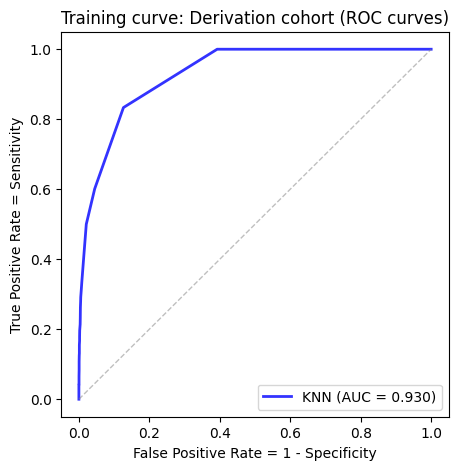

Training AUROC: 0.930 (95% CI: 0.915, 0.945)


In [27]:
# Predict on training data
pred_probas_train = clf.predict_proba(X_train)
risk_groups_train = results(pred_probas_train)

# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_train, pred_probas_train[:,1])
roc_auc = auc(fpr, tpr)
plot_ROC_curve(fpr, tpr, roc_auc, 'Training curve: Derivation cohort (ROC curves)')

# Compute AUROC CI
auroc_ci_lower_train, auroc_ci_upper_train = bootstrap_metric_ci(y_train, pred_probas_train[:,1], "auroc")

print(f"Training AUROC: {roc_auc:.3f} (95% CI: {auroc_ci_lower_train:.3f}, {auroc_ci_upper_train:.3f})")


Val


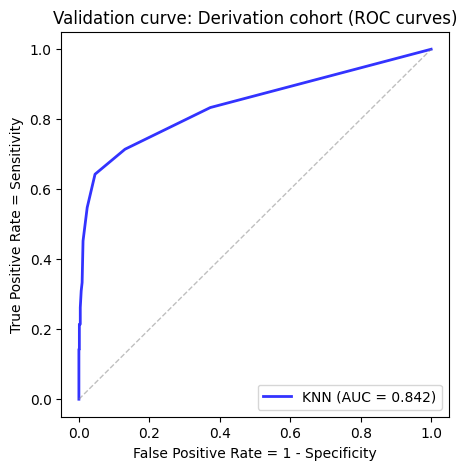

Val AUROC: 0.842 (95% CI: 0.762, 0.917)


In [28]:
# Evaluate on validation set
print("\nVal")
pred_probas_val = clf.predict_proba(X_val)
risk_groups_val = results(pred_probas_val)

# Compute ROC curve and area under the curve for validation set
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, pred_probas_val[:,1])
roc_auc_val = auc(fpr_val, tpr_val)
plot_ROC_curve(fpr_val, tpr_val, roc_auc_val, 'Validation curve: Derivation cohort (ROC curves)')

# Compute AUROC CI
auroc_ci_lower_val, auroc_ci_upper_val = bootstrap_metric_ci(y_val, pred_probas_val[:,1], "auroc")

print(f"Val AUROC: {roc_auc_val:.3f} (95% CI: {auroc_ci_lower_val:.3f}, {auroc_ci_upper_val:.3f})")


Val


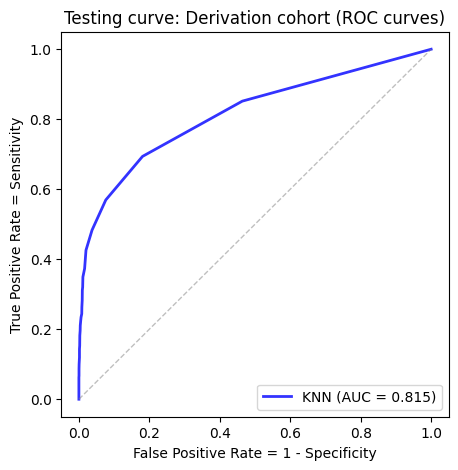

test AUROC: 0.815 (95% CI: 0.780, 0.850)


In [29]:
# Evaluate on validation set
print("\nVal")
pred_probas_test = clf.predict_proba(X_test)
risk_groups_test = results(pred_probas_test)

# Compute ROC curve and area under the curve for validation set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_probas_test[:,1])
roc_auc_test = auc(fpr_test, tpr_test)
plot_ROC_curve(fpr_test, tpr_test, roc_auc_test, 'Testing curve: Derivation cohort (ROC curves)')

# Compute AUROC CI
auroc_ci_lower_test, auroc_ci_upper_test = bootstrap_metric_ci(y_test, pred_probas_test[:,1], "auroc")

print(f"test AUROC: {roc_auc_test:.3f} (95% CI: {auroc_ci_lower_test:.3f}, {auroc_ci_upper_test:.3f})")